# Case study 2: The T signaling pathway

In [1]:
!pip install git+https://github.com/y0-causal-inference/eliater.git 

  Cloning https://github.com/y0-causal-inference/eliater.git to /private/var/folders/fs/kx46_43x04ndj3yryggvkg5r0000gn/T/pip-req-build-bjn8y2jg
  Running command git clone --quiet https://github.com/y0-causal-inference/eliater.git /private/var/folders/fs/kx46_43x04ndj3yryggvkg5r0000gn/T/pip-req-build-bjn8y2jg
  Resolved https://github.com/y0-causal-inference/eliater.git to commit 722814a686ef4771548cdbb0b9c59804014438c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import networkx as nx
import pandas as pd

#from eliater import version_df
from src.eliater.data import load_sachs_df
from eliater.discover_latent_nodes import (
    find_nuisance_variables,
    mark_nuisance_variables_as_latent,
    remove_nuisance_variables,
)
from eliater.examples import t_cell_signaling_example
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.estimation import estimate_ace
from y0.algorithm.identify import Identification, identify_outcomes
from y0.dsl import P, Variable

#version_df()

In [5]:
RAF = Variable("Raf")
ERK = Variable("Erk")

This is case study 2 in this paper: Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The Figure below is the protein signalling network (G) of the cell signaling pathway presented in (Sachs et al., 2005). It models the molecular
mechanisms and regulatory processes involved in T cell activation, proliferation, and function.

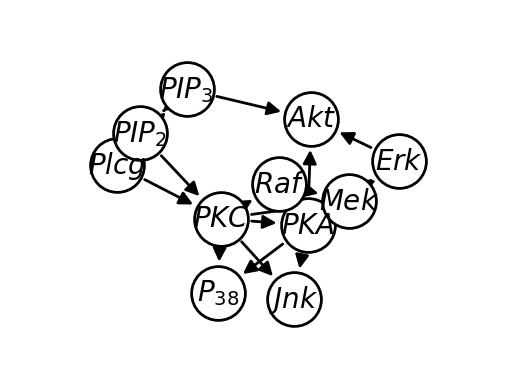

In [6]:
graph = t_cell_signaling_example.graph
graph.draw()

The observational data consisted of quantitative multivariate flow cytometry measurements of phosphorylated proteins derived from thousands of individual primary immune system cells. The cells were subjected to general stimuli meant to activate the desired paths. The distributions of measurements of individual proteins were skewed, and pairs of proteins exhibited nonlinear relationships. To account for that, the data were binned into
two levels corresponding to low, and high concentrations using Hartemink’s approach (Hartemink, 2001) to preserve
the dependence structure of the original data.

In [7]:
data = load_sachs_df()
data.head()

,Raf,Mek,Plcg,PIP2,PIP3,Erk,Akt,PKA,PKC,P38,Jnk
0,0,0,0,1,1,1,0,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1
2,1,0,0,1,1,1,1,1,1,0,0
3,1,0,0,1,1,1,1,1,1,0,0
4,0,0,1,1,0,1,1,1,1,1,1


## Step 1: Verify correctness of the network structure

In [8]:
print_graph_falsifications(graph, data, method="chi-square", verbose=True, significance_level=0.01)

Failed tests: 6/35 (17.14%)
Reject null hypothesis when p<0.01
======  =======  ============  ===========  ===========  =====  ===========  ===================
left    right    given               stats            p    dof        p_adj  p_adj_significant
======  =======  ============  ===========  ===========  =====  ===========  ===================
Erk     PIP3     PKC           478.923      0                2  0            True
Jnk     P38      PKA|PKC       171.716      0                4  0            True
Mek     Plcg     PKC           208.487      0                2  0            True
Erk     PIP2     PKC            89.0334     0                2  0            True
Plcg    Raf      PKC           249.869      0                2  0            True
Akt     PKC      Mek|PIP3|PKA   36.8493     1.22668e-05      8  0.000368005  True
PIP3    PKC      PIP2|Plcg      17.2052     0.00176329       4  0.0511354    False
P38     Plcg     PKC             8.17906    0.0167471        2  0.468918 

Out of 35 d-separations implied by the network, six failed. As the precentage of failed tests is below 30 percent, its effect on the estimation of causal query is minor. Hence, we proceed to the next step.

## Step 2: Check query identifiability

If the query is identifiable, the $Y_0$ package will return its estimand. Otherwise, nothing will be shown.

In [6]:
identify_outcomes(graph=graph, treatments=RAF, outcomes=ERK)

Sum[Mek, PIP2, PIP3, PKA, PKC, Plcg](P(Erk | Mek, PIP2, PIP3, PKA, PKC, Plcg, Raf) * P(Mek | PIP2, PIP3, PKA, PKC, Plcg, Raf) * P(PIP2 | PIP3, Plcg) * P(PIP3 | Plcg) * P(PKA | PIP2, PIP3, PKC, Plcg) * P(PKC | PIP2, PIP3, Plcg) * Sum[Erk, Mek, PIP2, PIP3, PKA, PKC, Raf](Sum[Akt, Jnk, P38](P(Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf))))

The query is identifiable. Hence, we can proceed to the next step.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [7]:
nuisance_variables = find_nuisance_variables(graph, treatments=RAF, outcomes=ERK)

print(f"The nuisance variables are {nuisance_variables}")

The nuisance variables are {Akt}


In [8]:
latent_variable_dag = mark_nuisance_variables_as_latent(
    graph,
    treatments=RAF,
    outcomes=ERK,
)

## Step 4: Simplify the network

In eliater, step 3, and 4 are both combined into a single function. Hence, the following function finds the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules (Step 4) to remove the nuisance variables. As a result, running the 'find_nuisance_variables' and 'mark_nuisance_variables_as_latent' functions is not necessary to get the value of step 4. However, we called them to illustrate the results. The new graph obtained in step 4 does not contain nuisance variables. 

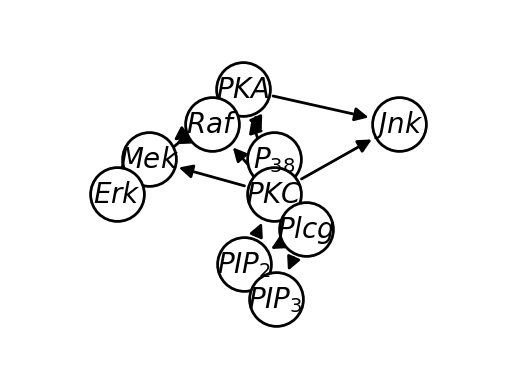

In [9]:
new_graph = remove_nuisance_variables(graph, treatments=RAF, outcomes=ERK)
new_graph.draw()

## Step 5: Estimate the query

In [10]:
estimate_ace(new_graph, treatments=RAF, outcomes=ERK, data=data)

-0.305808812806743